In [1]:
import h5py 
import numpy as np 
import scipy as sp
from scipy.interpolate import interp1d
# -- astropy--
from astropy.io import fits
from astropy.table import Table as aTable
# -- feasibgs -- 
from feasibgs import util as UT

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in the block catalog
fblock = h5py.File(''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.mockexp_block.lowHalpha.hdf5']), 'r')
block = {}
for g in fblock.keys():
    block[g] = {} 
    for k in fblock[g].keys(): 
        block[g][k] = fblock[g][k].value
magnorm_flag = block['forwardmodel']['magnorm_flag']    
fblock.close()

In [71]:
r_mag_legacy = UT.flux2mag(block['legacy-photo']['flux_r'])#, method='log')
r_mag_gama = block['gama-photo']['modelmag_r'] 
ztrue = block['gama-spec']['z']
ha_flux = block['gama-spec']['ha_flux']
r_mag_apflux = UT.flux2mag(block['legacy-photo']['apflux_r'][:,1])

Text(0,0.5,'H$\\alpha$ flux')

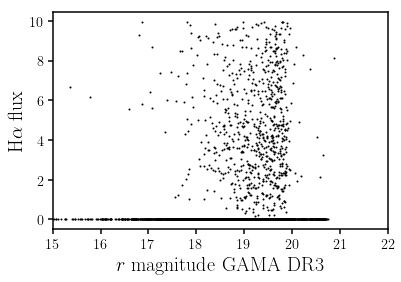

In [26]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(r_mag_gama, np.clip(ha_flux,0,None), c='k', s=1)
sub.set_xlabel(r'$r$ magnitude GAMA DR3', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ flux', fontsize=20)


In [7]:
# read exposures from file
fexp = h5py.File(''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.hdf5']), 'r')
exps = {} 
for k in fexp.keys(): 
    exps[k] = fexp[k].value

In [68]:
for k in exps.keys(): 
    print k, exps[k][2910]

AVAILABLE 187
MJD 59219.511622160455
AIRMASS 1.6034623564188002
STATUS 2
SNR2FRAC 0.8961211789795046
SEEING 1.11041259765625
MOONFRAC 0.6247875563975706
SUNALT -27.093541119769053
MOONSEP 53.372374367805506
SUNSEP 68.43449266004038
PLANNED 0
TRANSPARENCY 0.9672073125839233
MOONALT 59.52581499939334
COVERED 134
PASS 6
DEC 25.3
EXPTIME 799.1837941340281
TILEID 38507
RA 235.94000000000005


In [51]:
def zsuccess(zrr, ztrue, zwarn): 
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    return (dz_1pz < 0.003) & (zwarn == 0)# & magnorm_flag

def zsuccess_iexp(ztrue=None, sky='old'): 
    z_rr, z_warn = [], [] 
    if sky == 'old': 
        f_rr = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.sim_spectra.mockexp_block.lowHalpha.texp_default.iexp2910.KSsky.rr.fits'])
    elif sky == 'new':
        f_rr = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.sim_spectra.mockexp_block.lowHalpha.texp_default.iexp2910.newKSsky.rr.fits'])
    z_iblock = fits.open(f_rr)[1].data
    z_rr = z_iblock['Z']
    z_warn = z_iblock['ZWARN']
    return zsuccess(z_rr, ztrue, z_warn)

In [55]:
ks_zsuccess = zsuccess_iexp(ztrue=ztrue, sky='old') #zsuccess(zblock_ks0['Z'], ztrue, zblock_ks0['ZWARN'])
new_zsuccess = zsuccess_iexp(ztrue=ztrue, sky='new')

In [53]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

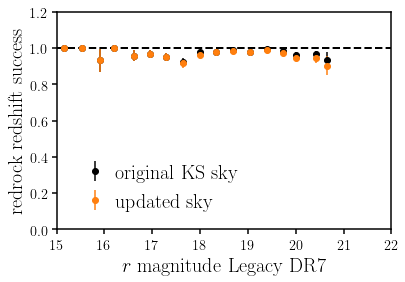

In [56]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_gama, ks_zsuccess, ((ha_flux <= 0.) & magnorm_flag), nbins=20, range=[15., 22.])
sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS sky')

mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_gama, new_zsuccess, ((ha_flux <= 0.) & magnorm_flag), nbins=20, range=[15., 22.])
sub.errorbar(mm, e1, ee1, color='C1', fmt='o', label='updated sky')

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.]) 
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})

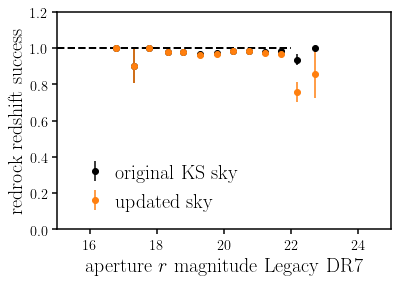

In [73]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_apflux, ks_zsuccess, ((ha_flux <= 0.) & magnorm_flag), nbins=20, range=[15., 25.])
sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS sky')

mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_apflux, new_zsuccess, ((ha_flux <= 0.) & magnorm_flag), nbins=20, range=[15., 25.])
sub.errorbar(mm, e1, ee1, color='C1', fmt='o', label='updated sky')

sub.set_xlabel(r'aperture $r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 25.]) 
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})

In [62]:
from desispec.io import read_spectra
bgs_spec_ks = read_spectra(''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.sim_spectra.mockexp_block.lowHalpha.texp_default.iexp2910.KSsky.fits']))
bgs_spec_new = read_spectra(''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.sim_spectra.mockexp_block.lowHalpha.texp_default.iexp2910.newKSsky.fits']))

In [48]:
i_spec = [] 
for i in range(5): 
    i_spec.append(np.random.choice(np.where((r_mag_gama > 20.-i) & (r_mag_gama < 21.-i))[0], size=1)[0])

(-5.0, 15.0)

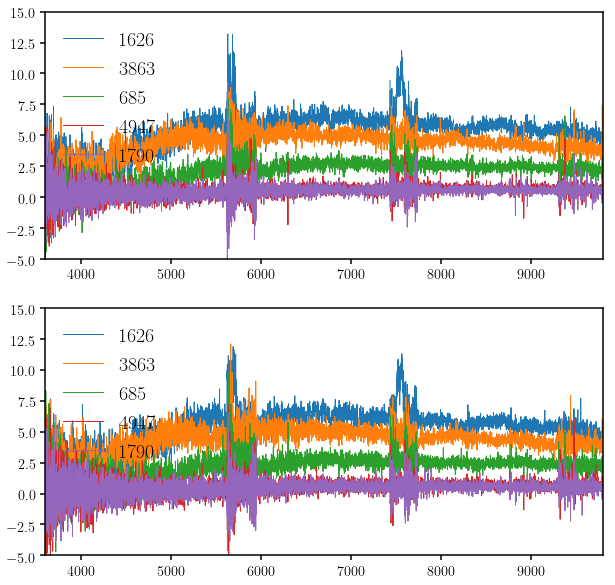

In [66]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(211)
for ii, i in enumerate(i_spec[::-1]): 
    for b in ['b', 'r', 'z']:
        lbl = None
        if b == 'b': lbl = str(i)
        sub.plot(bgs_spec_ks.wave[b], bgs_spec_ks.flux[b][i], c='C'+str(ii), lw=1, label=lbl)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylim([-5., 15.])

sub = fig.add_subplot(212)
for ii, i in enumerate(i_spec[::-1]): 
    for b in ['b', 'r', 'z']:
        lbl = None
        if b == 'b': lbl = str(i)
        sub.plot(bgs_spec_new.wave[b], bgs_spec_new.flux[b][i], c='C'+str(ii), lw=1, label=lbl)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylim([-5., 15.])

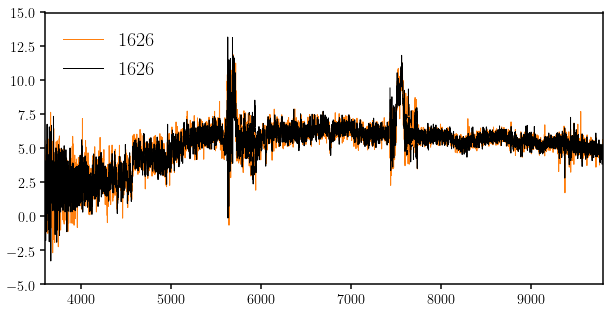

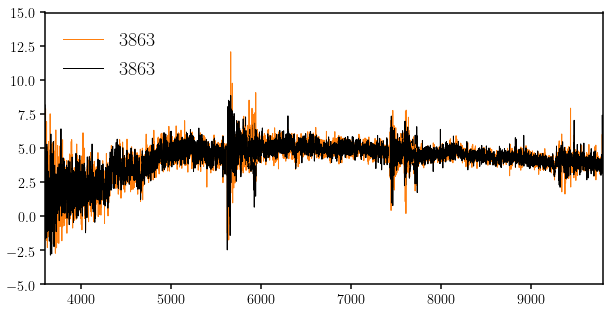

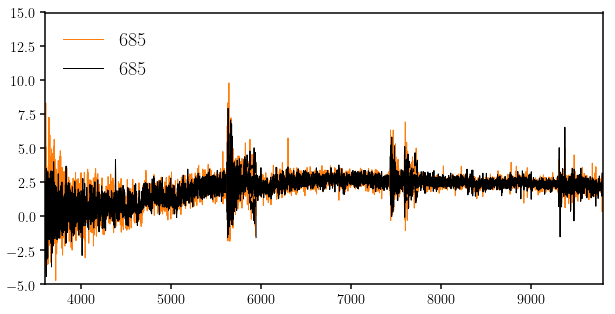

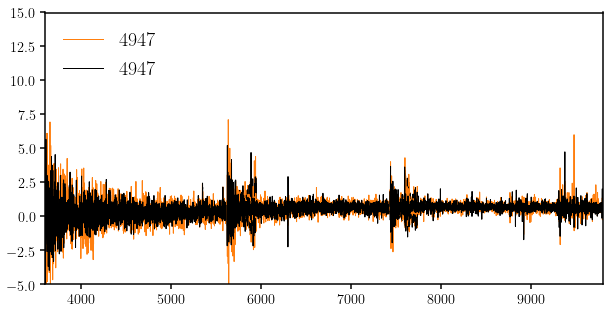

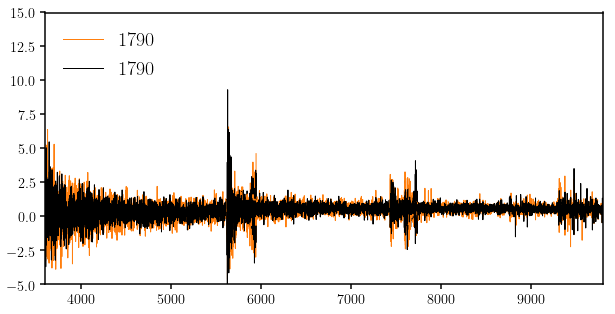

In [69]:
for ii, i in enumerate(i_spec[::-1]):
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111) 
    for b in ['b', 'r', 'z']:
        lbl = None
        if b == 'b': lbl = str(i)
        sub.plot(bgs_spec_new.wave[b], bgs_spec_new.flux[b][i], c='C1', lw=1, label=lbl)
        sub.plot(bgs_spec_ks.wave[b], bgs_spec_ks.flux[b][i], c='k', lw=1, label=lbl)
    sub.legend(loc='upper left', fontsize=20)
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([-5., 15])